In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import joblib

In [2]:
torch.cuda.is_available()

True

In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} - {torch.cuda.get_device_name(0)}")

Using device: cuda - NVIDIA GeForce RTX 3070


In [4]:
df = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")

In [5]:
df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [8]:
# List of features extracted by the feature extractor
extractable_features = [
    'URLLength', 'DomainLength', 'IsDomainIP', 'URLSimilarityIndex',
    'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength',
    'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar',
    'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL',
    'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL',
    'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
    'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength',
    'HasTitle', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon',
    'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect',
    'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit',
    'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields',
    'HasPasswordField', 'Bank', 'Pay'
]

# Keep only extractable features + label column
filtered_df = df[extractable_features + ['label']]

In [9]:
filtered_df

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,label
0,31,24,0,100.000000,1.000000,0.522907,0.061933,3,1,0,...,0,1,0,0,1,1,0,1,0,1
1,23,16,0,100.000000,0.666667,0.032650,0.050207,2,1,0,...,0,0,0,1,1,0,0,0,0,1
2,29,22,0,100.000000,0.866667,0.028555,0.064129,2,2,0,...,0,0,0,0,1,1,0,0,0,1
3,26,19,0,100.000000,1.000000,0.522907,0.057606,3,1,0,...,1,12,0,1,1,1,0,0,1,1
4,33,26,0,100.000000,1.000000,0.079963,0.059441,3,1,0,...,0,2,0,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235790,29,22,0,100.000000,1.000000,0.522907,0.058739,3,1,0,...,0,0,0,1,1,1,0,0,1,1
235791,28,21,0,100.000000,0.785714,0.028555,0.053834,2,2,0,...,0,0,0,1,1,1,0,0,1,1
235792,30,23,0,100.000000,1.000000,0.003319,0.063093,2,1,0,...,0,0,0,1,1,0,0,0,0,1
235793,55,47,0,28.157537,0.465116,0.000961,0.050211,3,2,0,...,0,2,0,0,1,1,1,0,0,0


In [17]:
# Separate features and target
X = filtered_df.drop(columns=['label']).values
y = filtered_df['label'].values

In [18]:
X

array([[31., 24.,  0., ...,  0.,  1.,  0.],
       [23., 16.,  0., ...,  0.,  0.,  0.],
       [29., 22.,  0., ...,  0.,  0.,  0.],
       ...,
       [30., 23.,  0., ...,  0.,  0.,  0.],
       [55., 47.,  0., ...,  1.,  0.,  0.],
       [33., 26.,  0., ...,  0.,  0.,  0.]], shape=(235795, 42))

In [19]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoader
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
# Simple feed-forward neural network
class PhishingModel(nn.Module):
    def __init__(self, input_size):
        super(PhishingModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Binary classification
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [22]:
# Initialize model, loss function, and optimizer
model = PhishingModel(input_size=X_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)
    
    # Evaluation
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct / total)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {test_losses[-1]:.4f}, Val Acc: {test_accuracies[-1]:.4f}")

Epoch 1/10, Train Loss: 0.0053, Train Acc: 0.9988, Val Loss: 0.0005, Val Acc: 0.9998
Epoch 2/10, Train Loss: 0.0006, Train Acc: 0.9999, Val Loss: 0.0006, Val Acc: 0.9999
Epoch 3/10, Train Loss: 0.0005, Train Acc: 0.9999, Val Loss: 0.0004, Val Acc: 0.9999
Epoch 4/10, Train Loss: 0.0004, Train Acc: 0.9999, Val Loss: 0.0003, Val Acc: 0.9999
Epoch 5/10, Train Loss: 0.0004, Train Acc: 0.9999, Val Loss: 0.0005, Val Acc: 0.9999
Epoch 6/10, Train Loss: 0.0004, Train Acc: 0.9999, Val Loss: 0.0004, Val Acc: 0.9999
Epoch 7/10, Train Loss: 0.0010, Train Acc: 0.9999, Val Loss: 0.0004, Val Acc: 0.9999
Epoch 8/10, Train Loss: 0.0003, Train Acc: 0.9999, Val Loss: 0.0003, Val Acc: 0.9999
Epoch 9/10, Train Loss: 0.0003, Train Acc: 0.9999, Val Loss: 0.0005, Val Acc: 0.9999
Epoch 10/10, Train Loss: 0.0004, Train Acc: 0.9999, Val Loss: 0.0006, Val Acc: 0.9999


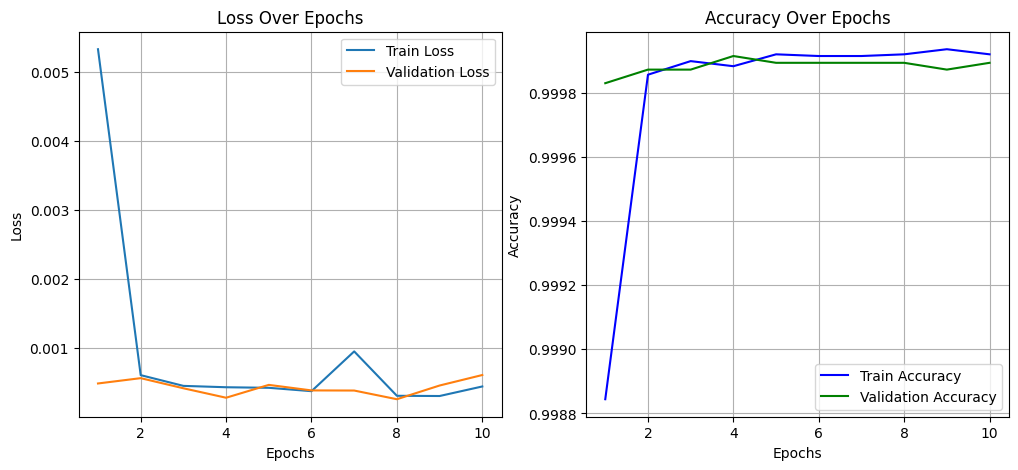

In [23]:

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, epochs+1), test_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Accuracy Over Epochs')
plt.show()

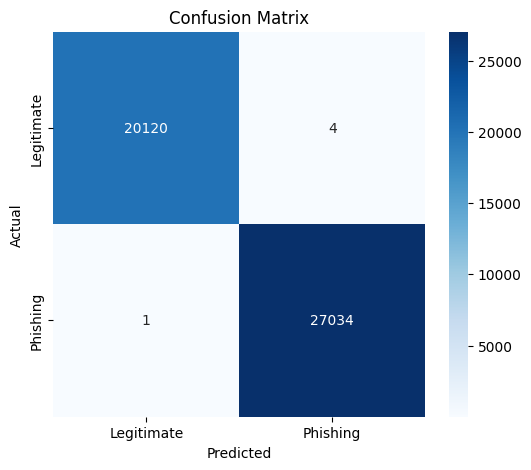

In [24]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# Save the model
torch.save(model.state_dict(), 'phishing_model_2.pth')
print("✅ Model saved successfully.")

# Save the scaler (if you used one)
joblib.dump(scaler, 'scaler2.pkl')
print("✅ Scaler saved successfully.")

✅ Model saved successfully.
✅ Scaler saved successfully.


Testing

In [46]:
input_size = 42  # Change this if your dataset has a different number of features
model = PhishingModel(input_size)

# Load the saved weights
model.load_state_dict(torch.load("phishing_model_2.pth"))

# Set the model to evaluation mode
model.eval()

PhishingModel(
  (fc1): Linear(in_features=42, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [51]:
from feature_extractor import extract_features

features = extract_features("https://www.uni-mainz.de")
features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(np.array([features]))
scaled_features

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [52]:
feature_tensor = torch.tensor(scaled_features, dtype=torch.float32).reshape(1, -1)
feature_tensor

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [53]:
with torch.no_grad():
    output = model(feature_tensor)
    prediction = torch.argmax(output, dim=1).item()  # Get class label (0 or 1)

print(f"Predicted class: {prediction}")

Predicted class: 0
